In [18]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [53]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['ACB']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2006-11-21,5.72,135.00,56500,7.371056e+09,0,0,120.00,150.00,119.00,0.00,0.00
1,2006-11-22,5.72,135.00,62300,8.390530e+09,0,0,143.20,143.20,130.00,4.80,3.69
2,2006-11-23,6.06,143.00,69900,9.676600e+09,0,0,145.00,145.00,130.00,8.30,6.16
3,2006-11-27,6.02,142.00,42400,6.225280e+09,0,0,146.80,161.40,135.00,-4.80,-3.27
4,2006-11-28,6.02,142.00,19800,2.835600e+09,0,0,150.00,150.00,140.00,-4.80,-3.27
...,...,...,...,...,...,...,...,...,...,...,...,...
4497,2024-12-17,25.20,25.20,3329200,8.368700e+10,2635039,68448512600,25.25,25.25,25.05,0.05,0.20
4498,2024-12-13,25.15,25.15,6040200,1.519990e+11,4609830,124604709000,25.30,25.30,25.10,-0.15,-0.59
4499,2024-12-18,25.15,25.15,3381500,8.506500e+10,147165,3965974250,25.25,25.25,25.10,-0.05,-0.20
4500,2024-12-19,24.80,24.80,9712000,2.418430e+11,2652044,68613329600,25.05,25.05,24.70,-0.35,-1.39


In [54]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4502 entries, 0 to 4501
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               4502 non-null   object 
 1   GiaDieuChinh       4502 non-null   float64
 2   GiaDongCua         4502 non-null   float64
 3   KhoiLuongKhopLenh  4502 non-null   int64  
 4   GiaTriKhopLenh     4502 non-null   float64
 5   KLThoaThuan        4502 non-null   int64  
 6   GtThoaThuan        4502 non-null   int64  
 7   GiaMoCua           4502 non-null   float64
 8   GiaCaoNhat         4502 non-null   float64
 9   GiaThapNhat        4502 non-null   float64
 10  ThayDoi_GiaTri     4502 non-null   float64
 11  ThayDoi_PhanTram   4502 non-null   float64
dtypes: float64(8), int64(3), object(1)
memory usage: 422.2+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,4502.000000,4502.000000,4.502000e+03,4.502000e+03,4.502000e+03,4.502000e+03,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000
mean,8.405951,36.592381,2.598210e+06,7.783811e+10,5.566408e+05,1.522350e+10,36.703321,37.240871,35.988150,0.026821,0.083634
std,6.209915,38.105372,3.769742e+06,1.113811e+11,4.998453e+06,1.416549e+11,38.563245,39.307407,37.102402,1.854082,2.132495
min,2.210000,14.500000,1.400000e+03,0.000000e+00,0.000000e+00,0.000000e+00,14.400000,14.600000,14.200000,-26.100000,-19.670000
25%,3.722500,20.600000,2.267500e+05,7.269125e+09,0.000000e+00,0.000000e+00,20.600000,20.900000,20.400000,-0.200000,-0.690000
50%,5.680000,25.000000,9.772235e+05,3.185016e+10,8.600000e+01,1.562000e+06,25.000000,25.250000,24.750000,0.000000,0.000000
75%,10.205000,33.400000,3.613275e+06,1.065546e+11,9.393200e+04,2.623500e+09,33.400000,33.800000,32.987500,0.200000,0.780000
max,26.250000,292.000000,3.515600e+07,1.246488e+12,2.052889e+08,5.963642e+12,300.000000,304.000000,284.000000,25.400000,9.990000


In [55]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

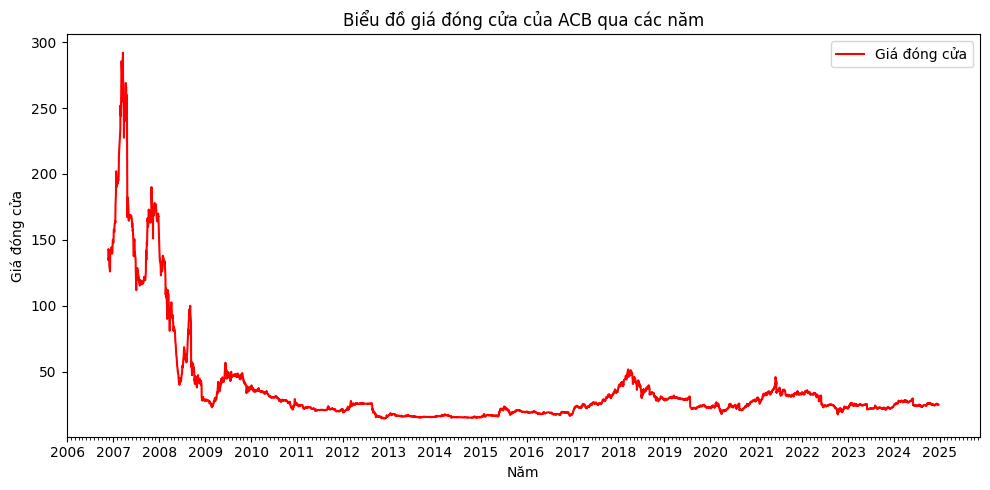

In [56]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của ACB qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [57]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [58]:
df1

,GiaDongCua
Ngay,
2006-11-21,135.00
2006-11-22,135.00
2006-11-23,143.00
2006-11-27,142.00
2006-11-28,142.00
...,...
2024-12-16,25.15
2024-12-17,25.20
2024-12-18,25.15


In [59]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [60]:
data

array([[135.  ],
       [135.  ],
       [143.  ],
       ...,
       [ 25.15],
       [ 24.8 ],
       [ 24.8 ]])

In [61]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [62]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [63]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.07683, saving model to save_models/ACB_model.keras
56/56 - 16s - 287ms/step - loss: 0.1825 - val_loss: 0.0768
Epoch 2/100

Epoch 2: val_loss improved from 0.07683 to 0.03247, saving model to save_models/ACB_model.keras
56/56 - 10s - 170ms/step - loss: 0.0411 - val_loss: 0.0325
Epoch 3/100

Epoch 3: val_loss improved from 0.03247 to 0.02807, saving model to save_models/ACB_model.keras
56/56 - 9s - 168ms/step - loss: 0.0204 - val_loss: 0.0281
Epoch 4/100

Epoch 4: val_loss improved from 0.02807 to 0.02746, saving model to save_models/ACB_model.keras
56/56 - 10s - 172ms/step - loss: 0.0153 - val_loss: 0.0275
Epoch 5/100

Epoch 5: val_loss improved from 0.02746 to 0.02030, saving model to save_models/ACB_model.keras
56/56 - 10s - 172ms/step - loss: 0.0141 - val_loss: 0.0203
Epoch 6/100

Epoch 6: val_loss did not improve from 0.02030
56/56 - 9s - 164ms/step - loss: 0.0129 - val_loss: 0.0261
Epoch 7/100

Epoch 7: val_loss improved from 0.

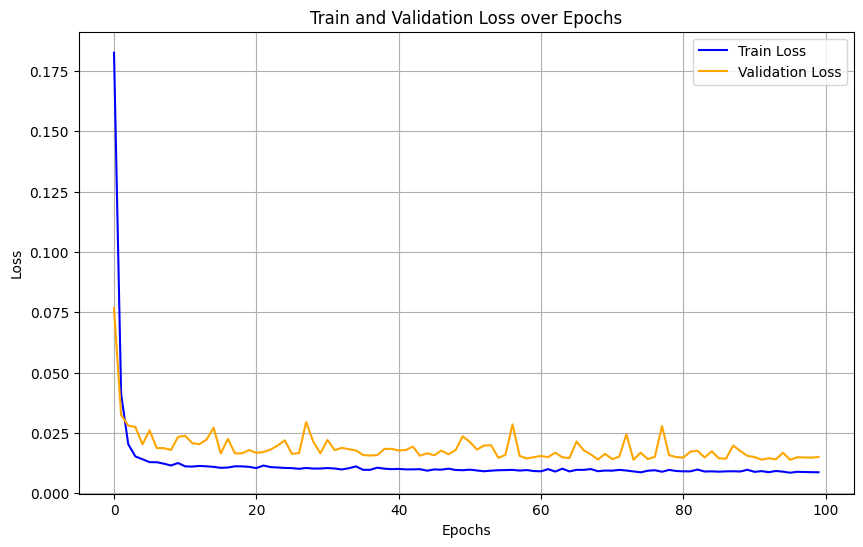

In [64]:
def build_model(input_shape):
    model = Sequential()
    
    # LSTM đầu tiên với L2 regularization
    model.add(LSTM(units=256, input_shape=input_shape, return_sequences=True, 
                   kernel_regularizer=l2(0.001)))
    
    # LSTM thứ hai với L2 regularization
    model.add(LSTM(units=128, kernel_regularizer=l2(0.001)))
    
    # Tăng Dropout để giảm overfitting
    model.add(Dropout(0.5))
    
    # Lớp Dense để đưa ra kết quả dự đoán
    model.add(Dense(1))
    
    # Compile mô hình với learning rate thấp để ổn định huấn luyện
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])  # Điều chỉnh để phù hợp với đầu vào
model = build_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/ACB_model.keras"

# Callbacks: ModelCheckpoint và EarlyStopping
callbacks = [
    ModelCheckpoint(save_model_path, monitor='val_loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình và lưu kết quả vào history
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
save_model_path = "save_models/ACB_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [66]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step


In [67]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1500:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


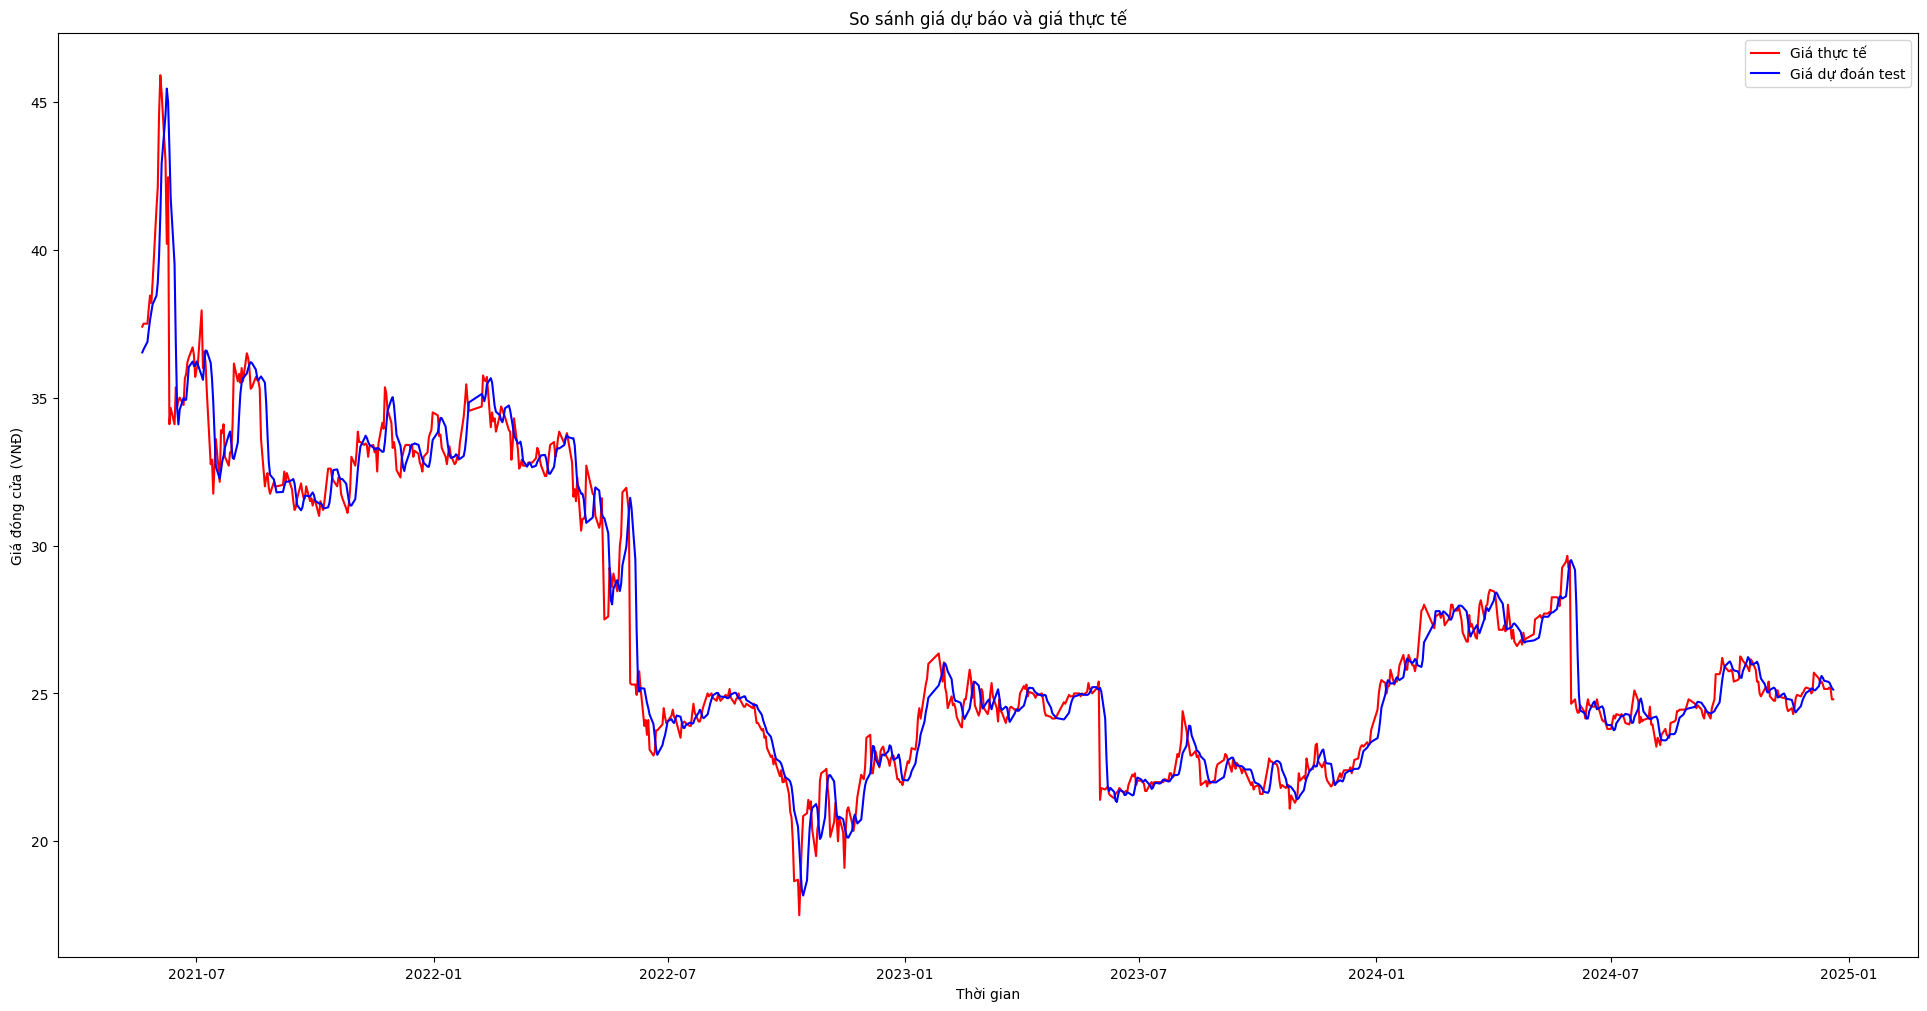

In [68]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(24, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [69]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9919895578712289
Sai số tuyệt đối trung bình trên tập train (VNĐ): 1.2268723530555838
Phần trăm sai số tuyệt đối trung bình trên tập train: 2.46842840158615
RMSE trên tập train (VNĐ): 3.5668785477388845
Độ chính xác trên tập train (%): 98.71463836117518
F1 Score trên tập train: 1.0
----------------------------------------------------


In [70]:
y_test = data[-len(y_test_predict):]

In [71]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9568067651842106
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.5734104520605089
Phần trăm sai số tuyệt đối trung bình trên tập test: 2.1072952628613204
RMSE trên tập test (VNĐ): 0.9936730912444006
Độ chính xác trên tập test (%): 96.5011510871676
F1 Score trên tập test: 1.0
----------------------------------------------------
